In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import seaborn as sns

In [84]:
df = pd.read_csv('prepared_data.csv')
df['payment_date'] = pd.to_datetime(df['payment_date']).dt.date

In [85]:
grouped = df.groupby('account_id').agg({
    'payment_date': ['min', 'max', 'count'], 
    'payment_amount': 'sum',
    'gender': 'first',
    'village': 'first',
    'age_group': 'first',
    'age': 'first'
}).reset_index()

grouped.columns = [
    'account_id',
    'first_payment_date',
    'last_payment_date',
    'frequency',  
    'total_amount', 
    'gender',
    'village',
    'age_group',
    'age'
]

current_date = datetime.datetime.now()
grouped['recency'] = (current_date - pd.to_datetime(grouped['last_payment_date'])).dt.days
grouped['survival_time_in_days'] = list(map(lambda x: x.days ,grouped['last_payment_date']-grouped['first_payment_date'] ))
grouped['avg_daily_payment_amount'] = grouped['total_amount']/grouped['survival_time_in_days'] 

In [86]:
grouped['R_rank'] = grouped['recency'].rank( ascending=False) 
grouped['F_rank'] = grouped['frequency'].rank(ascending=True)
grouped['M_rank'] = grouped['total_amount'].rank(ascending=True)
grouped['R_rank_norm']=(grouped['R_rank']/grouped['R_rank'].max())*100
grouped['F_rank_norm']=(grouped['F_rank']/grouped['F_rank'].max())*100
grouped['M_rank_norm']=(grouped['F_rank']/grouped['M_rank'].max())*100
grouped.head()

,account_id,first_payment_date,last_payment_date,frequency,total_amount,gender,village,age_group,age,recency,survival_time_in_days,avg_daily_payment_amount,R_rank,F_rank,M_rank,R_rank_norm,F_rank_norm,M_rank_norm
0,4,2016-09-25,2023-02-11,90,297854.5,male,Lichk,40-60,59,295,2330,127.834549,915.5,1291.5,1120.0,61.795478,87.086986,87.086986
1,8,2016-01-11,2023-02-11,58,313900.0,male,Yeranos,60+,32,295,2588,121.290572,915.5,939.0,1147.0,61.795478,63.317599,63.317599
2,9,2016-01-18,2023-03-09,83,374000.0,female,Lichk,60+,20,269,2607,143.459916,1383.0,1222.0,1268.0,93.351333,82.400539,82.400539
3,10,2016-02-12,2023-02-06,61,381850.0,male,Vardadzor,60+,54,300,2551,149.686397,809.5,985.0,1292.0,54.640567,66.419420,66.419420
4,12,2016-01-27,2023-02-01,104,479019.0,female,Vardenis,Under 30,26,305,2562,186.970726,711.0,1333.5,1382.0,47.991900,89.919083,89.919083


In [87]:
grouped['RFM_Score']=0.25*grouped['R_rank_norm']+0.25*grouped['F_rank_norm']+0.5*grouped['M_rank_norm']
grouped=grouped.round(0)
grouped.head()

,account_id,first_payment_date,last_payment_date,frequency,total_amount,gender,village,age_group,age,recency,survival_time_in_days,avg_daily_payment_amount,R_rank,F_rank,M_rank,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score
0,4,2016-09-25,2023-02-11,90,297854.0,male,Lichk,40-60,59,295,2330,128.0,916.0,1292.0,1120.0,62.0,87.0,87.0,81.0
1,8,2016-01-11,2023-02-11,58,313900.0,male,Yeranos,60+,32,295,2588,121.0,916.0,939.0,1147.0,62.0,63.0,63.0,63.0
2,9,2016-01-18,2023-03-09,83,374000.0,female,Lichk,60+,20,269,2607,143.0,1383.0,1222.0,1268.0,93.0,82.0,82.0,85.0
3,10,2016-02-12,2023-02-06,61,381850.0,male,Vardadzor,60+,54,300,2551,150.0,810.0,985.0,1292.0,55.0,66.0,66.0,63.0
4,12,2016-01-27,2023-02-01,104,479019.0,female,Vardenis,Under 30,26,305,2562,187.0,711.0,1334.0,1382.0,48.0,90.0,90.0,79.0


In [88]:
grouped["customer_segment"] = np.where( grouped['RFM_Score'] < 25 ,"Leaving Customers", (
                             np.where(grouped['RFM_Score'] < 50 , "Risky Customers", (
                            np.where(grouped['RFM_Score'] < 75 , "Potential Loyalists", "Champions")))))

grouped.head()

,account_id,first_payment_date,last_payment_date,frequency,total_amount,gender,village,age_group,age,recency,survival_time_in_days,avg_daily_payment_amount,R_rank,F_rank,M_rank,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,customer_segment
0,4,2016-09-25,2023-02-11,90,297854.0,male,Lichk,40-60,59,295,2330,128.0,916.0,1292.0,1120.0,62.0,87.0,87.0,81.0,Champions
1,8,2016-01-11,2023-02-11,58,313900.0,male,Yeranos,60+,32,295,2588,121.0,916.0,939.0,1147.0,62.0,63.0,63.0,63.0,Potential Loyalists
2,9,2016-01-18,2023-03-09,83,374000.0,female,Lichk,60+,20,269,2607,143.0,1383.0,1222.0,1268.0,93.0,82.0,82.0,85.0,Champions
3,10,2016-02-12,2023-02-06,61,381850.0,male,Vardadzor,60+,54,300,2551,150.0,810.0,985.0,1292.0,55.0,66.0,66.0,63.0,Potential Loyalists
4,12,2016-01-27,2023-02-01,104,479019.0,female,Vardenis,Under 30,26,305,2562,187.0,711.0,1334.0,1382.0,48.0,90.0,90.0,79.0,Champions


In [89]:
grouped[['account_id','customer_segment']].to_csv("customer_segment.csv",index=False)

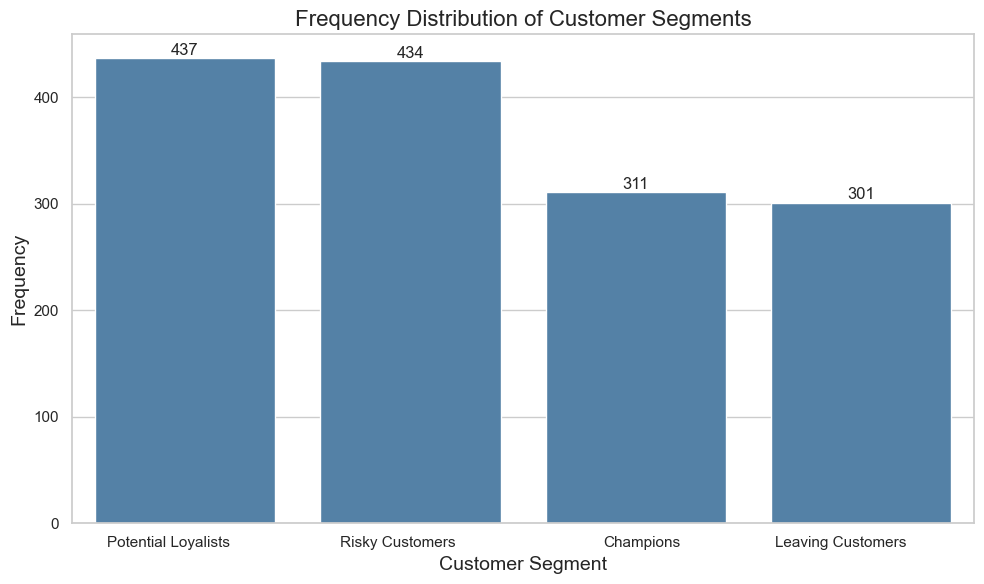

In [90]:
frequency_distribution = grouped['customer_segment'].value_counts().reset_index()
frequency_distribution.columns = ['Customer Segment', 'Frequency']

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='Customer Segment', y='Frequency', data=frequency_distribution, color="steelblue")
plt.xlabel('Customer Segment', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Frequency Distribution of Customer Segments', fontsize=16)
plt.xticks(rotation=0, ha='right') 
for index, value in enumerate(frequency_distribution['Frequency']):
    plt.text(index, value + 0.1, str(value), ha='center', va='bottom')
tick_positions = [i + 0.2 for i in range(len(frequency_distribution))]
plt.xticks(tick_positions, frequency_distribution['Customer Segment'])
plt.tight_layout()  
plt.show()

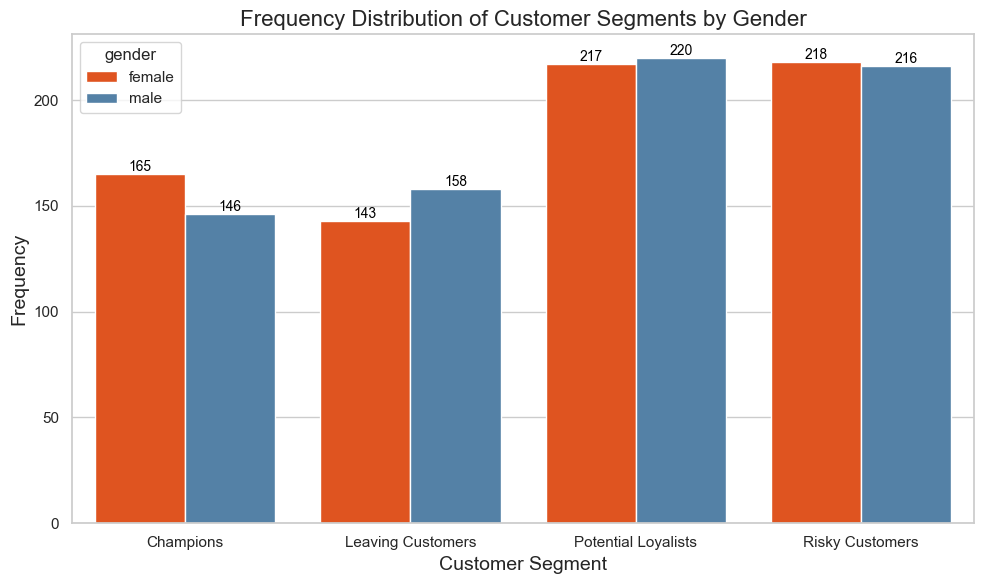

In [91]:
frequency_distribution = grouped.groupby(['customer_segment', 'gender']).size().reset_index(name='Frequency')

custom_palette = {'male': 'steelblue', 'female': '#FF4500'}
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.barplot(x='customer_segment', y='Frequency', hue='gender', data=frequency_distribution, palette=custom_palette)

plt.xlabel('Customer Segment', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Frequency Distribution of Customer Segments by Gender', fontsize=16)

for p in plt.gca().patches:
    if p.get_height() == 0:
        continue
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                       textcoords='offset points')

plt.tight_layout()
#plt.savefig("gender_plot.png")
plt.show()


In the above plot, it is evident that the "Champions" segment comprises more females (165) compared to males (146). The "Leaving Customers" segment presents a balanced gender distribution, with females slightly outnumbering males (158 to 143). In the "Potential Loyalists" category, the gender frequency is almost equal, though males (220) marginally exceed females (217). Similarly, the "Risky Customers" segment shows a nearly identical count between genders, with a minimal male majority (218 males versus 216 females).

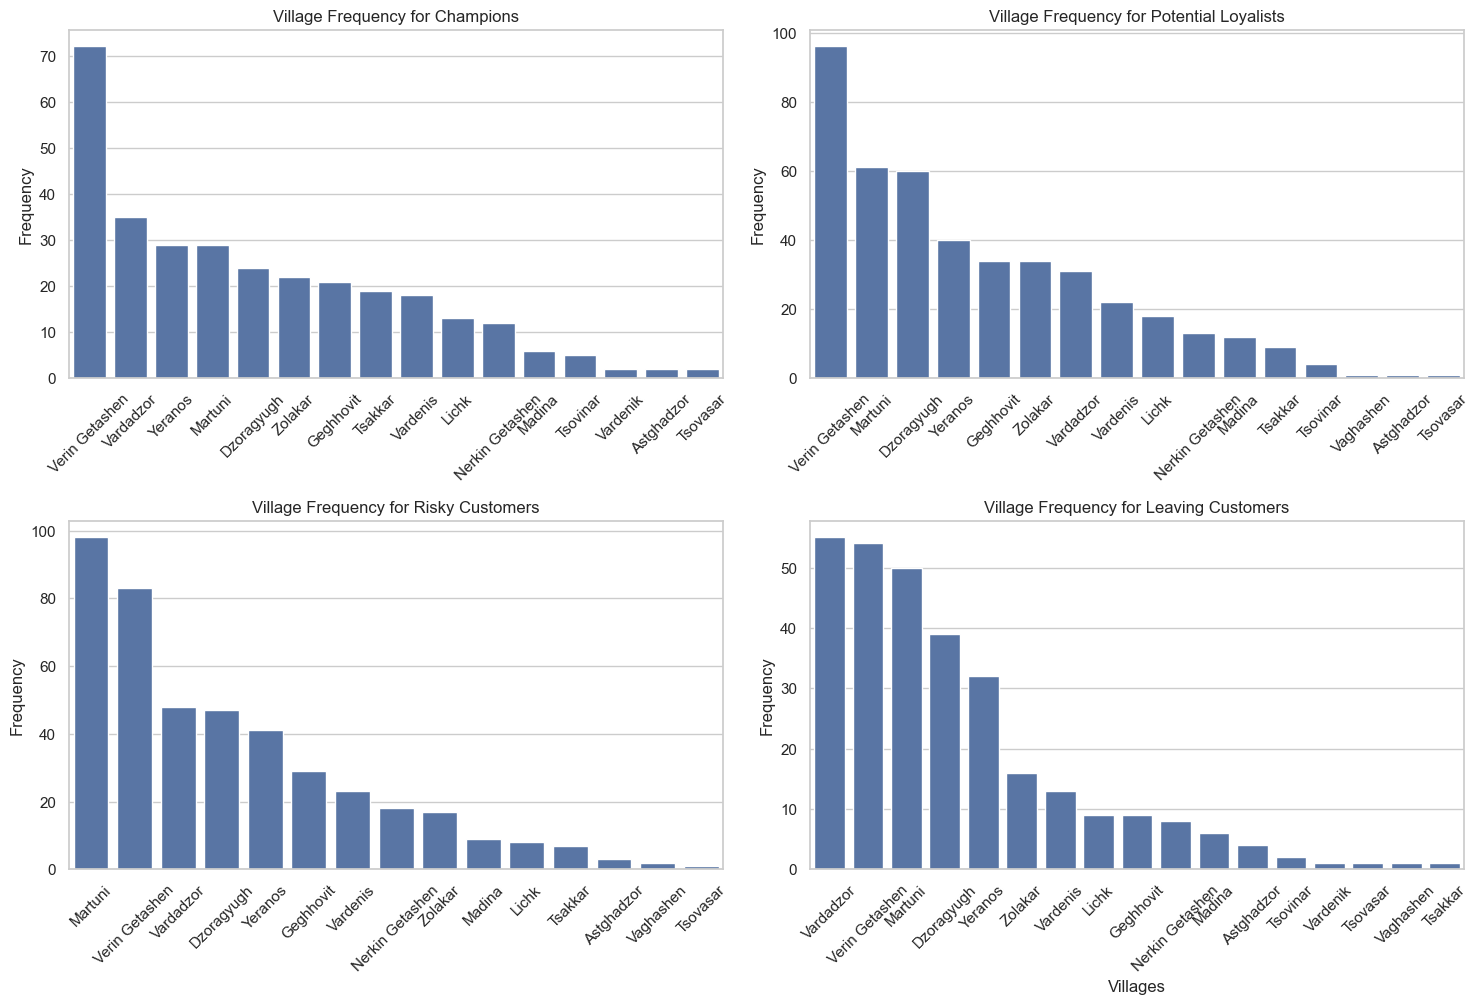

In [95]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
segments = ['Champions', 'Potential Loyalists', 'Risky Customers', 'Leaving Customers']

for i, segment in enumerate(segments):
    segment_data = grouped[grouped['customer_segment'] == segment]

    village_frequency = segment_data['village'].value_counts().reset_index()
    village_frequency.columns = ['Village', 'Frequency']

    sns.barplot(x='Village', y='Frequency', data=village_frequency, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'Village Frequency for {segment}')
    axes[i//2, i%2].set_xlabel('')
    axes[i//2, i%2].set_ylabel('Frequency')
    axes[i//2, i%2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.xlabel("Villages")

#plt.savefig("village_plot.png")
plt.show()


Martuni has the highest number of 'Risky Customers', while Verin Getashen leads with 'Potential Loyalists' and is also prominent across other segments. 'Leaving Customers' are most numerous in Vardadzor, and Verin Getashen again ranks high in this segment. Smaller villages like Tsovasar and Vaghashen have very few customers across all segments, indicating either smaller populations or less engagement. Among the villages, Verin Getashen holds a substantial number of 'Champions', though fewer than its 'Potential Loyalists' and 'Risky Customers', while Martuni, despite its high-risk customer count, has a comparatively moderate presence of 'Champions'.



<Figure size 1000x600 with 0 Axes>

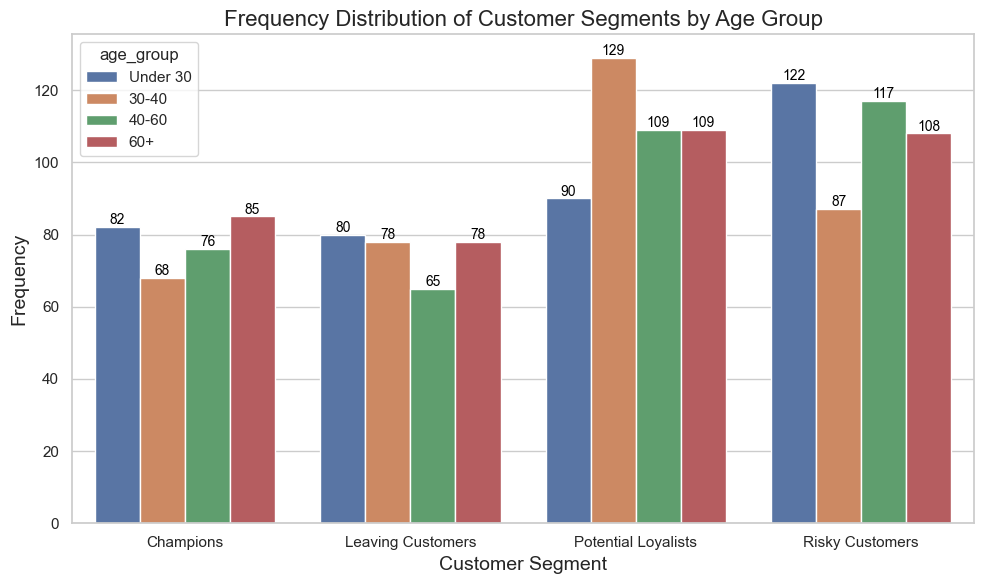

In [101]:

frequency_distribution = grouped.groupby(['customer_segment', 'age_group']).size().reset_index(name='Frequency')

age_group_order = ['Under 30', '30-40', '40-60', '60+']

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='customer_segment', y='Frequency', hue='age_group', data=frequency_distribution, hue_order=age_group_order)

plt.xlabel('Customer Segment', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Frequency Distribution of Customer Segments by Age Group', fontsize=16)


for p in plt.gca().patches:
    if p.get_height() == 0:
        continue
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                       textcoords='offset points')

plt.tight_layout()
#plt.savefig("age_group_customer_segmentation_plot.png")

plt.show()



'Champions' are most frequent above 60 years, suggesting loyalty grows with age. 'Potential Loyalists' are largest in the 30-40 age group, indicating a strong middle-aged customer base. 'Risky Customers' are mainly under 30, hinting at uncertainty with younger clients. 'Leaving Customers' are spread evenly across age groups, with slightly fewer in the 40-60 range.
